# Detecting COVID-19 using X-ray and Deep Learning using ResNet-18

Using Custom Dataset

# Importing Libraries

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import os

%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Preparing the Dataset

In [3]:
class_names = ['normal', 'pneumonia', 'covid']
root_dir    = 'core-dataset'
source_dirs = ['NORMAL', 'PNEUMONIA', 'COVID']
         

# Creating Custom Dataset

In [4]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name): # Take all images regardless of the format
            images = [x for x in os.listdir(image_dirs[class_name]) if (x.lower().endswith('jpeg') or x.lower().endswith('jpg') or x.lower().endswith('png'))] 
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'pneumonia', 'covid']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
          
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [5]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [6]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [7]:
train_dirs = {
    'normal': 'core-dataset/normal',
    'pneumonia': 'core-dataset/pneumonia',
    'covid': 'core-dataset/covid'
}

In [8]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1341 normal examples
Found 3875 pneumonia examples
Found 396 covid examples


In [9]:
test_dirs = {
    'normal': 'core-dataset/test/normal',
    'pneumonia': 'core-dataset/test/pneumonia',
    'covid': 'core-dataset/test/covid'
}

In [10]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 234 normal examples
Found 390 pneumonia examples
Found 100 covid examples


In [11]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 936
Number of test batches 121


# Data Visualization

In [12]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.cpu().numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].cpu().numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].cpu().numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

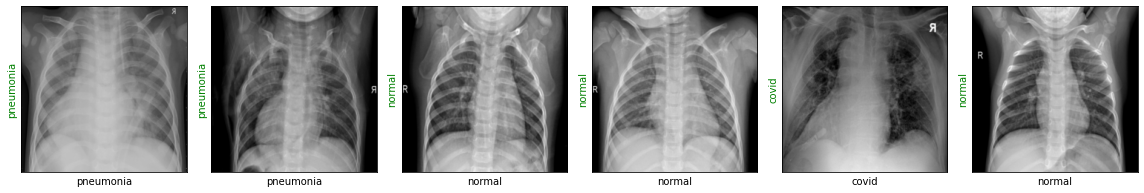

In [13]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

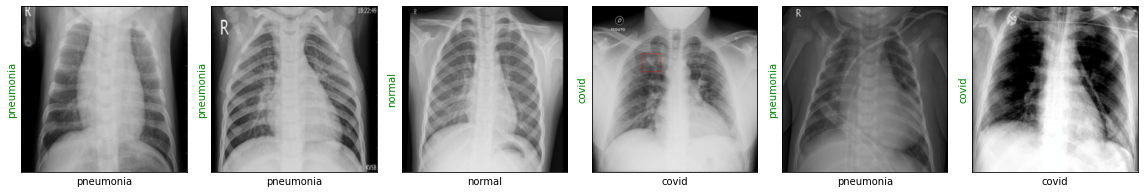

In [14]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Preparing the pretrained ResNet-18 model

In [15]:
resnet18 = torchvision.models.resnet18(pretrained = True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
resnet18.fc = torch.nn.Linear(in_features = 512, out_features = 3)
loss_fn     = torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.Adam(resnet18.parameters(), lr = 3e-5)

In [17]:
resnet18.to(device)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    images = images.to(device)
    labels = labels.to(device)
    print(type(images))
    print(images.shape)
    print(images[0].shape)
    outputs  = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

torch.Size([3, 224, 224])


/home/vjaiwantx/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


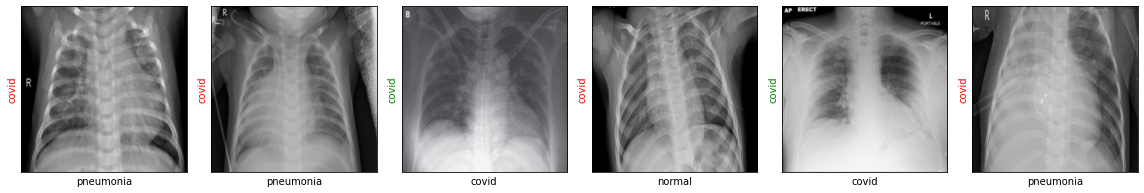

In [19]:
show_preds()

# Training and Testing the Model

In [20]:
train_loss_arr=[]
val_loss_arr=[]
accuracy_arr=[]
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                accuracy = 0
                resnet18.eval() # set model to eval phase
                for val_step, (images, labels) in enumerate(dl_test):
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).cpu().numpy())
                    
                train_loss /= (train_step + 1)
                val_loss /= (val_step + 1)
                accuracy = 100 * accuracy/len(test_dataset)
                val_loss_arr.append(val_loss*100)
                train_loss_arr.append(train_loss*100)
                accuracy_arr.append(accuracy)
                print(f'Training Step: {train_step}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}%')
                resnet18.train()
                if accuracy >= 95.00 and val_loss <= 0.01:
                    print('Performance condition satisfied, stopping..')
                    return
                  
        train_loss /= (train_step + 1)
        train_loss_arr.append(train_loss)
        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')
    if torch.cuda.is_available(): torch.cuda.empty_cache()

In [21]:
%%time

train(epochs=1)

Starting training..
Starting epoch 1/1
Training Step: 0, Training Loss: 0.9791, Validation Loss: 1.4037, Accuracy: 33.7017%
Training Step: 20, Training Loss: 0.9412, Validation Loss: 0.7826, Accuracy: 64.7790%
Training Step: 40, Training Loss: 0.2606, Validation Loss: 0.5196, Accuracy: 79.8343%
Training Step: 60, Training Loss: 0.1483, Validation Loss: 0.3580, Accuracy: 87.0166%
Training Step: 80, Training Loss: 0.0774, Validation Loss: 0.2813, Accuracy: 88.8122%
Training Step: 100, Training Loss: 0.0611, Validation Loss: 0.2926, Accuracy: 87.9834%
Training Step: 120, Training Loss: 0.0471, Validation Loss: 0.3398, Accuracy: 87.1547%
Training Step: 140, Training Loss: 0.0306, Validation Loss: 0.3441, Accuracy: 87.8453%
Training Step: 160, Training Loss: 0.0351, Validation Loss: 0.2591, Accuracy: 91.4365%
Training Step: 180, Training Loss: 0.0236, Validation Loss: 0.2469, Accuracy: 92.6796%
Training Step: 200, Training Loss: 0.0196, Validation Loss: 0.3561, Accuracy: 86.4641%
Training S

# Final Results

<class 'torch.Tensor'>
torch.Size([6, 3, 224, 224])
torch.Size([3, 224, 224])


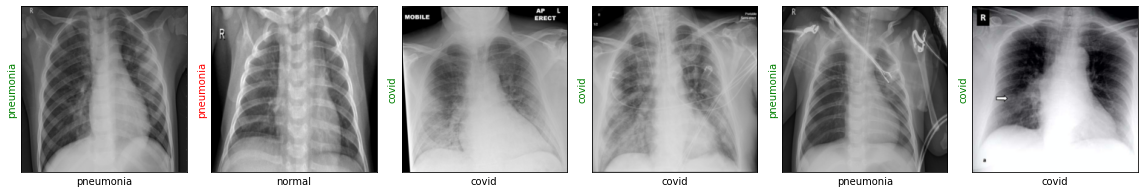

In [30]:
show_preds()

In [31]:
print("Accuracy:",accuracy_arr[-1],"%")

Accuracy: 83.97790055248619 %


In [24]:
torch.save(resnet18.state_dict(),"model2-resnet18.pth")

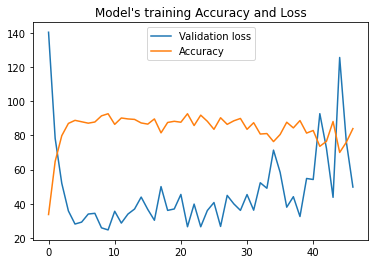

In [25]:
#plt.plot(np.arange(0,train_loss_arr[0]*100,1)[::-1],label="Training loss")
plt.plot(val_loss_arr,label="Validation loss")
plt.plot(accuracy_arr,label="Accuracy")
plt.title("Model's training Accuracy and Loss")
plt.legend()

In [26]:
'''
RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 3-dimensional input of size [3, 224, 224] instead
'''

'\nRuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 3-dimensional input of size [3, 224, 224] instead\n'